# Abgabe 6 Industrielle Kristallisation

---

Bearbeitet von Michael Ruß 25.06.23

## Bibliotheken und Plotfunktion

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from cycler import cycler

In [2]:
# Allgemeine Plotfunktion
def plot_Graph(x_list,y_lists,x_label ='x_label',y_label='y_label',figname=None,log=False):

  # Automatische Farbzuweisung an KIT Farben angepasst blue -> maygreen -> red -> yellow
  default_cycler = (cycler(color=['#4664aa','#8cb63c','#a22223','#fce500','#009682']))
  plt.rc('axes', prop_cycle=default_cycler)

  fig, ax = plt.subplots()
  # Jedes y_lists Element muss aus einem 2er Tupel bestehen: Den y Werten und dem Namen der Datenreihe
  for y_list, name in y_lists:
    ax.plot(x_list,y_list,label=name, linewidth=2.0)

  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.grid()

  # Wertebereiche des Graphen an min/max Wertebereich anpassen (etwas enger als die Standardskalierung)
  y_scaler = 1.05
  x_scaler = 1.05
  miny = y_lists[0][0][0]
  maxy = y_lists[0][0][0]
  for y_list, name in y_lists:
    if miny > min(y_list):
      miny = min(y_list)
    if maxy < max(y_list):
      maxy = max(y_list)

  ax.set(xlim=(x_list[0]*x_scaler,x_list[-1]*x_scaler),
         ylim=((y_scaler*miny),(y_scaler*maxy)))

  if log:
    plt.yscale("log")

  # Erstelle eine Legende bei mehr als einer Datenreihe, positioniere sie optimal auf der rechten Seite und setze die Transparenz auf 0
  if len(y_lists) > 1:
    plt.legend(loc ='best',bbox_to_anchor=(0.5, 0., 0.5, 1),framealpha=1)

  # Wenn der Graph einen Namen hat, speichere ihn mit der Auflösung dpi
  if figname != None:
    fig.savefig(figname, dpi=300)

## Berechnungsfunktionen

### Wachstumkinetik und Keimbildungskinetik

In [1]:
# Wachstumsrate berechnen
def calcG(kg,rho,l,dx):
  # Kristallwachstum bei Übersättigung, ansonsten kein Wachstum -> negativ schrumpfen?
  if dx >= 0.00:
  #if True:
    return(kg*rho*dx)

  else:
    return 0

# Birthrate berechnen
def calcB0(kb,dx,b):
  if dx >=0.00:
    return(kb*math.pow(dx,b))
  else:
    return 0

### N0 und Nt Berechnung

In [2]:
# Left Boundary
def N0calc(N0,B0,V,dL,tau,dt,G):
  return(N0 + (B0*V-G*N0/dL-N0/tau)*dt)

# Central Difference
def NtcalcCE(dL,dt,tau,G,Np,Ni,Nm):
  return(Ni+dt*(-G*(Np-Nm)/(2*dL)-Ni/tau))

# Backwards Difference
def NtcalcBW(dL,dt,tau,G,Np,Ni,Nm):
  return(Ni+dt*(-G*(Ni-Nm)/(dL)-Ni/tau))

# Flux limiter
def flux(Np,Ni,Nm):
  phi = 0
  if (Np-Ni)!=0:
      r = (Ni-Nm)/(Np-Ni)

      # Flux limiter nach van Albada 1 - symmetric
      phi = (r**2+r)/(r**2+1)
  return phi

## Kristallanzahl, Kristallfläche, Feststoffanteil

In [3]:
# Berechnen der Partikeloberfläche aus der Verteilung
# Annahme: Partikel der jeweiligen Größenklasse sind kugelförmig und monodispers
def A_total_calc(L_class,n_class):
  A_crystal = 0
  for i in range(len(L_class)):
    A_crystal += math.pow(L_class[i],2)*n_class[i]
  A_crystal = A_crystal*math.pi
  return A_crystal

# Funktion zur Berechnung der Gesamtpartikelzahl
def N_total_calc(n_class):
  Ntotal = 0
  for n_class in n_class:
    Ntotal +=n_class
  return Ntotal

# Feststoffanteil im Kristallisator
def x_solid_calc(Ms,Ml):
  return(Ms/(Ms+Ml))

## Massenbilanz

In [4]:
def massenBilanz(konstPara,x,Ms,Ml,As,G):

  # Unpacking für Lesbarkeit
  rhos,rhol,xsat,xf,Fpkt,Bpkt,dt = konstPara

  # m
  dx = x-xsat

  # (14a)
  # n
  Mpkt = As*rhos*G/2

  #Mpkt +=B_0 * V * rhos * (math.pi / 6) * (5e-5)**3

  # (20)
  # n
  Lpkt = (Fpkt-Bpkt-Mpkt*(1-rhol/rhos))/(1+(rhol*Ms)/(rhos*Ml))

  # (15) repräsentativer Produktabzug
  # n
  Spkt = Lpkt*Ms/Ml

  # (13)
  # n
  x = x + dt/Ml * (Fpkt*(xf-x)+Bpkt*x+Mpkt*(x-1))

  # (8) L Bilanz
  # n+1
  Ml = Ml + dt * (Fpkt-Bpkt-Lpkt-Mpkt)
  # (9) S Bilanz
  # n+1
  Ms = Ms + dt*(Mpkt-Spkt)

  return x,Ms,Ml



## Time Solver

In [7]:
def timeSolver(Parameter,Anfangswerte,Time_list,L_classes,N_0):

  # Parameterliste in nachvollziehbare Variablen entpacken
  dt,dL,tau,V,g,rhos,rhol,xsat,xf,Fpkt,Bpkt,phi,limiter,b = Parameter

  x,Ms,Ml,As,G,B0 = Anfangswerte

  print('Parameter',Parameter)
  print('Anfangswerte',Anfangswerte)

  # Übergeben der Anfangswerte an die Variablen, die kontinuierlich überschrieben werden und deklaration vor den ersten Funktionsaufrufen
  xc = x
  Msc = Ms
  Mlc = Ml
  Asc = As
  Gc = G
  B0c = B0

  # Kopieren der Liste und Einführung von vereinfachten Variablen zum Rechnen
  N_i = N_0.copy()
  classNr = len(L_classes)
  massBilKonstants = [rhos,rhol,xsat,xf,Fpkt,Bpkt,dt]

  # Leere Listen zum Abspeichern berechneter Variablen über die Zeit
  A_list = []
  x_solid_list = []
  dx_list = []
  G_list = []
  Ml_list = []
  Ms_list = []

  # Zeitschleife
  for i, time_element in enumerate(Time_list):
    # c indiziert, dass die Variable für den aktuellen Zeitschritt verwendet wird

    xc,Msc,Mlc = massenBilanz(massBilKonstants,xc,Msc,Mlc,Asc,Gc)

    # Berechnung der aktuellen Übersättigung
    dxc = xc-xsat

    # Darauf basierend wird die aktuelle Wachstumsrate bestimmt
    Gc = calcG(kg,rhos,g,dxc)

    # Birthrate berechnen
    B0c = calcB0(kb,dxc,b)

    # Randbedingung für N0
    N_i[0]= N0calc(N_i[0],B0c,V,dL,tau,dt,Gc)

    # Größenklassenschleife: Iterieren der Gleichung (6-16) mit central difference
    for j, element in enumerate(L_classes,start=1):
      if j<classNr-1:
        N_icentral = NtcalcCE(dL,dt,tau,Gc,N_i[j+1],N_i[j],N_i[j-1])
        N_ibackward = NtcalcBW(dL,dt,tau,Gc,N_i[j+1],N_i[j],N_i[j-1])

        # Flux limiter (wenn false, phi konstanter Parameter - wenn true Berechnung nach Vorschrift)
        if limiter:
          phi = flux(N_i[j+1],N_i[j],N_i[j-1])
        # Gewichtung von zwei Approximationen des Gradienten mit Phi
        N_i[j] = N_ibackward + phi*(N_icentral-N_ibackward)

    # Neumann RB für L = 0 Option:
    # L_i[0]=L_i[1]

    # Neumann RB  für die großen Laengenklassen
    N_i[-1]= N_i[-2]

    # Dirichlet RB für scharfe Trennung ab Lmax
    #N_i[-1]=0

    # Berechnung der Kristallfläche aus der Anzahlverteilung
    Asc = A_total_calc(L_classes,N_i)

    # Speicherlisten
    A_list.append(Asc)

    #x_solid_list.append(x_solid_calc(Msc,Mlc))
    x_solid_list.append(xc)
    Ml_list.append(Mlc)
    Ms_list.append(Msc)
    dx_list.append(dxc)
    G_list.append(Gc)

  # Endwerte ausgeben
  print('Asc ',Asc)
  print('Gc ',Gc)
  print('B0c ',B0c)
  print('dxc ',dxc)
  print('Msc ',Msc)
  print('Mlc ',Mlc)
  print('N0 ',N_i[0])

  return A_list,x_solid_list,dx_list,N_i,G_list,Ml_list,Ms_list

## Parameter

In [58]:
# Numerische Parameter
dt = 180
tmax = 3600*50
Lmax = 5e-3
classNr = 100
# Flux limiter Optionen. Phi = 1: Zentrale Differenz, Phi = 0: Backward Differenz, limiter = True: Phi = [0,1]
phi = 1
limiter = False

# Stoffwerte
rhoS = 1769
rhoL = 1250
x_sat = 0.45
x_f = 0.4
g = 1
# Birthrate Potenzabhänigkeit der Übersättigung
b = 4


# Stoffstromvorgaben und Anfangswerte
Fpkt = 10e3/3600
Bpkt = 3e3/3600
V = 20
x0 = 0
A0 = 0
Ms0 = 0
Ml0 = rhoL*V
G0 = 0
B0 = 0


# Zeit und Größenklassenlisten
t_range = np.arange(0,tmax+dt,dt)

l_classes = np.linspace(0,Lmax,classNr)
dL = l_classes[1]-l_classes[0]
l_mid = l_classes + dL


# Daten aus Beer MSMPR

G_beer = 2.6e-7
#tau = 293
tau = rhoL*V/(Fpkt)
n0_beer = 3.1e13
# Gesamtpartikelzahl in Hausaufgabe 3 berechnet
Nges_beer = 2.36e9

dx_beer = 0.02

# konstanter Kristallwachstumskoeffizient kg aus stationärem MSMPR
kg = G_beer/(rhoS*(dx_beer))
# konstanter Keimbildungskoeffizient kb aus stationärem MSMPR
kb = n0_beer*G_beer/(math.pow(dx_beer,2))


# Übergabelisten
Parameters = [dt,dL,tau,V,g,rhoS,rhoL,x_sat,x_f,Fpkt,Bpkt,phi,limiter,b]
Variables = [x0,Ms0,Ml0,A0,G0,B0]
N0 = [0] * len(l_classes)

## Ausführung und Plotten

In [59]:
# Berechnen und Ausgabe von Endwerten
A_list,x_solid_list,dx_list,N_i_list,G_list,Ml_list,Ms_list = timeSolver(Parameters,Variables,t_range,l_classes,N0)

Parameter [180, 5.0505050505050505e-05, 9000.0, 20, 1, 1769, 1250, 0.45, 0.4, 2.7777777777777777, 0.8333333333333334, 1, False, 4]
Anfangswerte [0, 0, 25000, 0, 0, 0]
Asc  2421.770552286316
Gc  1.6974741158038557e-07
B0c  585.7526790972727
dxc  0.013057493198491199
Msc  5363.5629710685835
Mlc  21210.031818069117
N0  3315957.9584205654


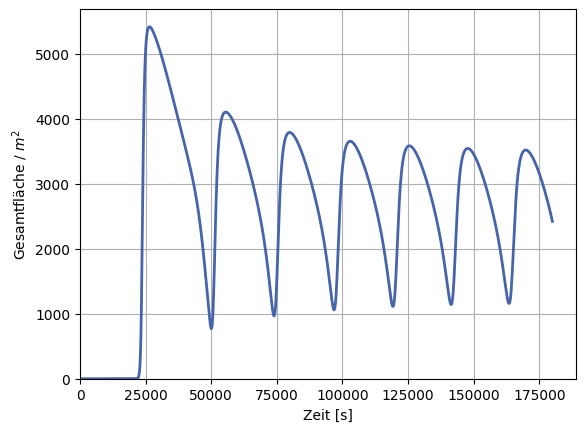

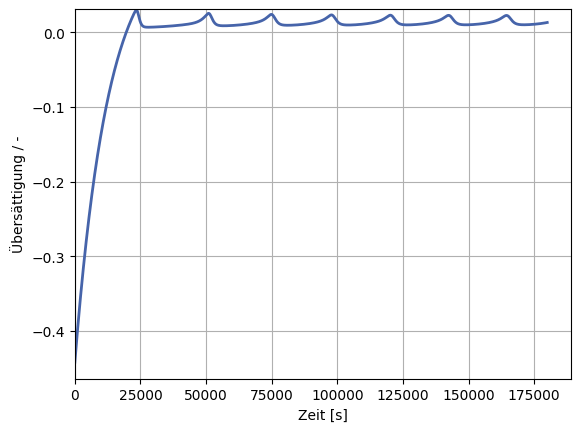

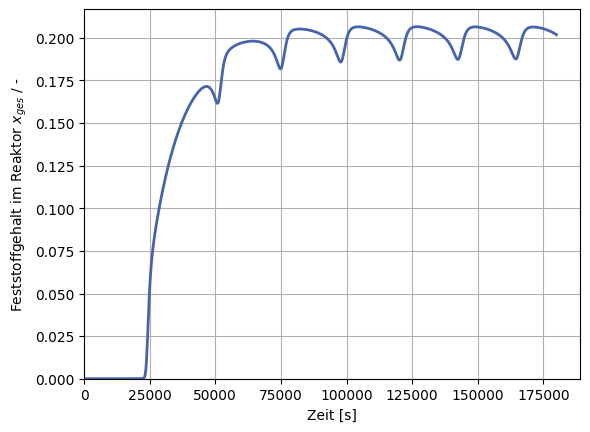

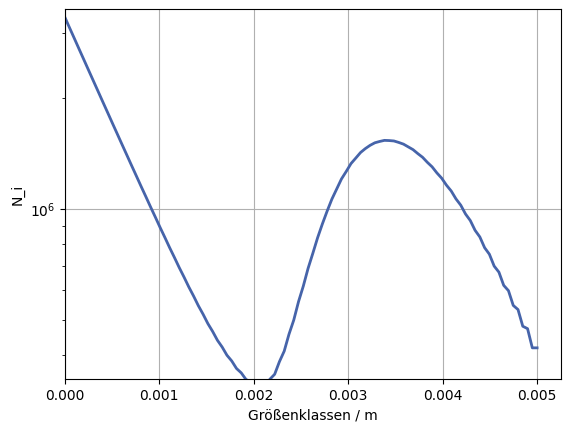

In [60]:

# Volumenbezogener Feststoffanteil
MsV_list = [x / V for x in Ms_list]
MlV_list = [x / V for x in Ml_list]
#
x_ges = [x_solid_calc(Ms_list[x],Ml_list[x]) for x in range(len(Ms_list))]

# Argumente für die Plotfunktion definieren
A = [[A_list,'$A_{Kristall}$']]
x_solid = [[x_solid_list,'$x_{solid}$']]
dx_sat = [[dx_list,'$dx_{}$']]
N_distr =[[N_i_list,'$N_{i}$']]
G = [[G_list,'$G$']]
Msc = [Ms_list,'$Ms$']
Msl = [Ml_list,'$Ml$']
Masses = [Msc,Msl]

MsV = [MsV_list,'$Ms$']
MlV = [MlV_list,'$Ml$']
x_ges = [[x_ges,'xges']]

MassesV = [MsV,MlV]

# Aufruf verschiedener Plotfunktionen Syntax:
# x_list: Eine x Achsenliste []
# y_lists =[[List,Name],[List,Name]] bzw
# y1 = [List1,Name1] y2 = [List2,Name2]
# y_lists = [y1,y2]
# Einzelgraph: y_lists = [[List,Name]]

# Letztes Argument log=True -> logarithmische Darstellung (Standard: Nicht logarithmisch)

plot_Graph(t_range,A,x_label='Zeit [s]',y_label='Gesamtfläche / $m^{2}$',figname=None)
plot_Graph(t_range,dx_sat,x_label='Zeit [s]',y_label='Übersättigung / -',figname=None)
#plot_Graph(t_range,x_solid,x_label='Zeit [s]',y_label='Feststoffanteil',figname=None)
#plot_Graph(t_range,Masses,x_label='Zeit [s]',y_label='Feststoffanteil / $kg/m^{3}$',figname=None)
plot_Graph(t_range,x_ges,x_label='Zeit [s]',y_label='Feststoffgehalt im Reaktor $x_{ges}$ / -',figname=None)
#plot_Graph(t_range,Masses,x_label='Zeit [s]',y_label='Masses',figname=None)
plot_Graph(l_classes,N_distr,x_label='Größenklassen / m',y_label='N_i',figname=None,log=True)